In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")



First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [2]:
import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0], 
                        "X2" : X[:,1],
                        "Label" : y})

circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
circles.Label.value_counts()

Label
1    500
0    500
Name: count, dtype: int64

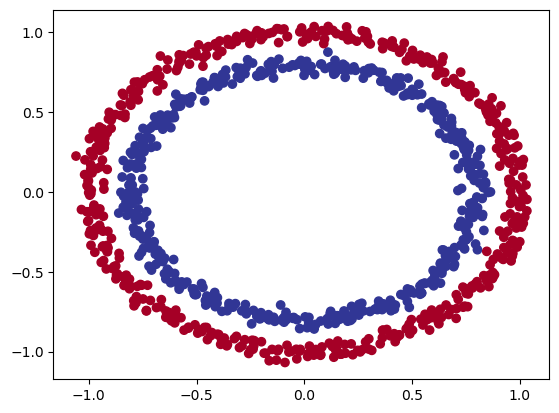

In [4]:
import matplotlib.pyplot as plot

plot.scatter(x=X[:,0],
             y=X[:,1],
             c=y,
             cmap=plot.cm.RdYlBu)


In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [8]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

In [9]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


In [10]:
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2 , out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.6257],
        [0.6462],
        [0.3694],
        [0.6992],
        [0.0477],
        [0.0627],
        [0.3753],
        [0.2378],
        [0.3833],
        [0.6440]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0')


In [13]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.1)


In [14]:
def accuracy_fn (y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.6257],
        [0.6462],
        [0.3694],
        [0.6992],
        [0.0477]], device='mps:0', grad_fn=<SliceBackward0>)

In [16]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0', grad_fn=<SqueezeBackward0>)

In [17]:
y_test[:5]

tensor([1., 0., 1., 0., 1.], device='mps:0')

In [18]:
torch.manual_seed(42)

epochs = 100
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
    
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if(epoch%10==0):
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71294, Accuracy: 52.75% | Test loss: 0.71844, Test acc: 52.50%
Epoch: 10 | Loss: 0.70019, Accuracy: 54.87% | Test loss: 0.70571, Test acc: 52.50%
Epoch: 20 | Loss: 0.69584, Accuracy: 53.87% | Test loss: 0.70094, Test acc: 49.00%
Epoch: 30 | Loss: 0.69429, Accuracy: 52.25% | Test loss: 0.69890, Test acc: 48.50%
Epoch: 40 | Loss: 0.69369, Accuracy: 51.62% | Test loss: 0.69786, Test acc: 49.50%
Epoch: 50 | Loss: 0.69342, Accuracy: 51.50% | Test loss: 0.69720, Test acc: 48.00%
Epoch: 60 | Loss: 0.69328, Accuracy: 50.75% | Test loss: 0.69674, Test acc: 45.50%
Epoch: 70 | Loss: 0.69319, Accuracy: 50.62% | Test loss: 0.69638, Test acc: 46.50%
Epoch: 80 | Loss: 0.69313, Accuracy: 50.50% | Test loss: 0.69609, Test acc: 46.00%
Epoch: 90 | Loss: 0.69309, Accuracy: 50.88% | Test loss: 0.69586, Test acc: 47.00%


In [19]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


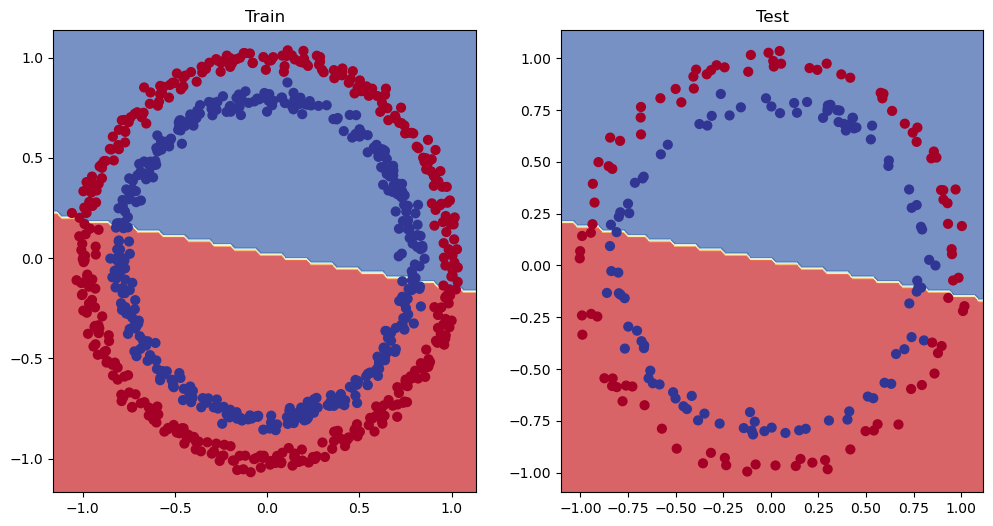

In [20]:
# Plot decision boundaries for training and test sets
plot.figure(figsize=(12, 6))
plot.subplot(1, 2, 1)
plot.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plot.subplot(1, 2, 2)
plot.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [21]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [22]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


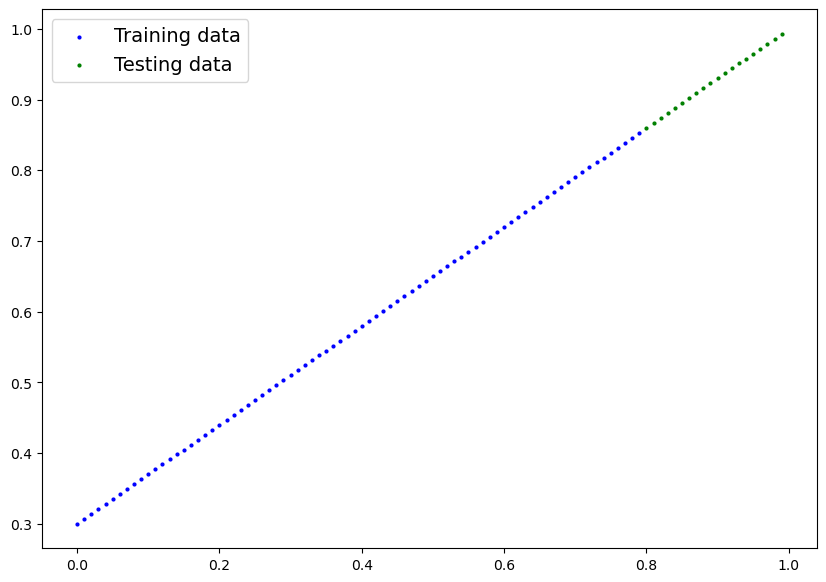

In [23]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [24]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [26]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


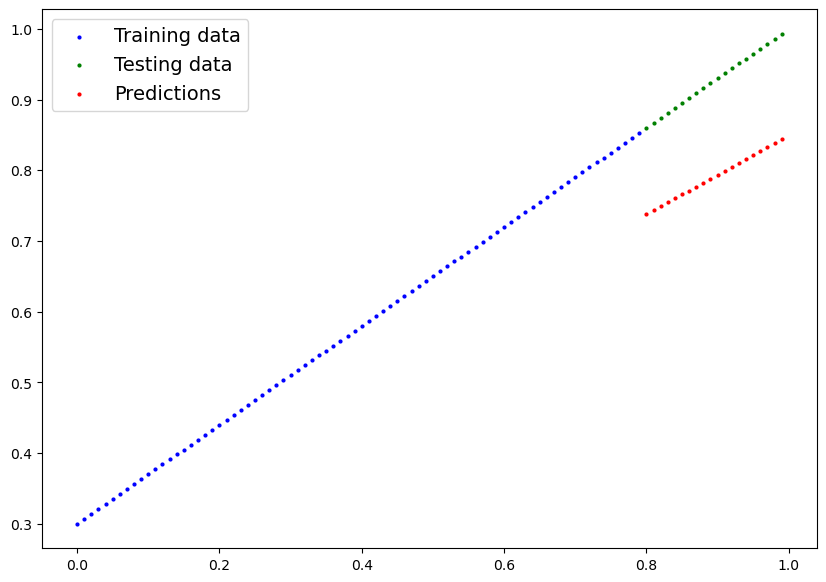

In [27]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

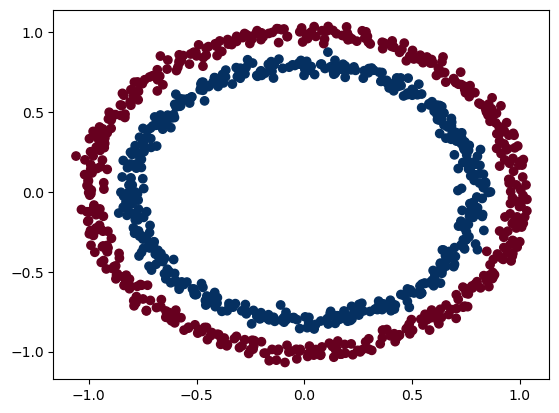

In [28]:
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdBu)

In [29]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train,X_test ,y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

X_train[:5], y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [52]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)

model_3
device

'mps'

In [54]:
# Setup loss and Optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.2)


In [55]:
#training loop

torch.manual_seed(42)

epoch = 10000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # Optim step 
    optimizer.step()


    # Testing
    model_3.eval()
    with torch.inference_mode():
        #forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #calc loss and acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # What's happening? 
        # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69312, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68978, Accuracy: 53.37% | Test Loss: 0.68938, Test Accuracy: 55.50%
Epoch: 200 | Loss: 0.68518, Accuracy: 52.75% | Test Loss: 0.68409, Test Accuracy: 56.50%
Epoch: 300 | Loss: 0.67520, Accuracy: 54.37% | Test Loss: 0.67282, Test Accuracy: 56.50%
Epoch: 400 | Loss: 0.65179, Accuracy: 63.88% | Test Loss: 0.64756, Test Accuracy: 67.50%
Epoch: 500 | Loss: 0.56917, Accuracy: 87.50% | Test Loss: 0.57400, Test Accuracy: 86.50%
Epoch: 600 | Loss: 0.37245, Accuracy: 97.88% | Test Loss: 0.40668, Test Accuracy: 92.50%
Epoch: 700 | Loss: 0.30881, Accuracy: 87.12% | Test Loss: 0.34613, Test Accuracy: 81.50%
Epoch: 800 | Loss: 0.09464, Accuracy: 99.88% | Test Loss: 0.13391, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.05634, Accuracy: 99.88% | Test Loss: 0.08544, Test Accuracy: 99.50%


In [56]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

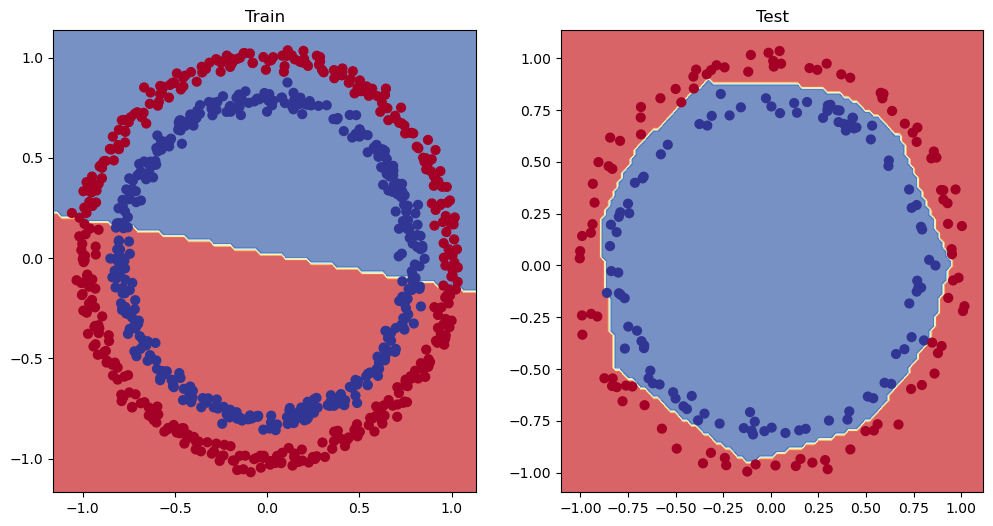

In [57]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

The output above did not have a nicely formed circle as I had not given the model enough capacity to learn the data. By increasing the number of hidden units and layers, the model can now learn more complex patterns in the data, resulting in a better fit to the circular distribution. See the circle coming into shape!

I adjusted the lr in the optimizer to 0.2 from 0.1 as well to help the model converge faster.

In [35]:
A = torch.arange(-10, 10, dtype=torch.float32)

A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

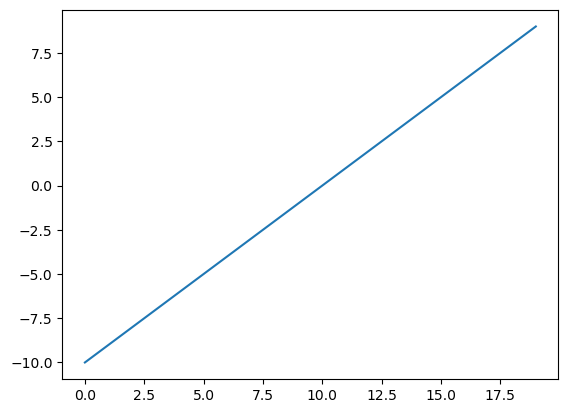

In [36]:
plt.plot(A)

In [37]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

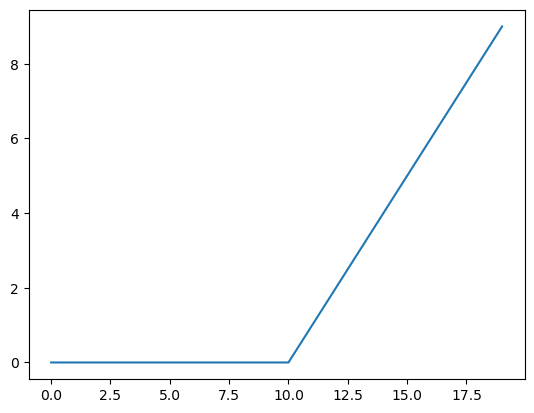

In [38]:
plt.plot(relu(A))

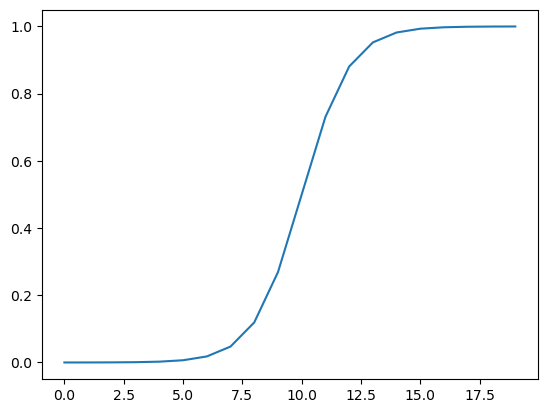

In [39]:
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

plt.plot(sigmoid(A))

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


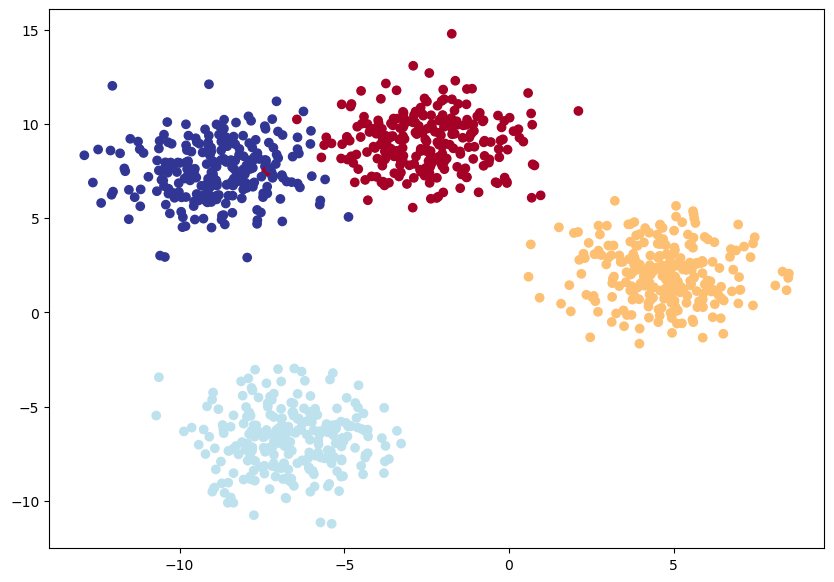

In [41]:
import torch
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


# Setting. up the hyperparams for data

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
# Generate data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, 
                            cluster_std=1.5, random_state=RANDOM_SEED)


# convert data into tensors 

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# divide data

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# plot data

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap = plt.cm.RdYlBu)





1. make_blobs is a data generation function from the sklearn.datasets module that creates synthetic datasets for clustering and classification tasks. It generates isotropic Gaussian blobs for clustering. Isotropic means that the blobs are evenly distributed in all directions, and Gaussian refers to the normal distribution used to create the blobs. This function is commonly used for testing and benchmarking clustering algorithms. 

2. random_state is a parameter used to control the randomness of the data generation process. By setting a specific integer value for random_state, you ensure that the generated dataset is reproducible. This means that every time you run the code with the same random_state value, you will get the same dataset. This is particularly useful for debugging and comparing results across different runs or experiments
3. cluster_std is a parameter that defines the standard deviation of the clusters generated by the make_blobs function. It controls how tightly or loosely the data points are grouped around the cluster centers. A smaller cluster_std value results in more tightly packed clusters, while a larger value leads to more spread-out clusters. Adjusting this parameter can help simulate different levels of noise and variability in the data, which can be useful for testing the robustness of clustering algorithms. 

In [45]:
# we already have the device configured so I am going to skip it.

device

'mps'

In [62]:
from torch import nn

class Blob_model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = Blob_model(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

Blob_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [63]:
# adding the loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)



In [64]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='mps:0',
       grad_fn=<SliceBackward0>)

In [69]:
print (model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES)
# 
y_logits= model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits,dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

# 

torch.Size([4]) 4
tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [70]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='mps:0')


Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct). 

In [75]:
# Lets train the model now! 

torch.manual_seed(RANDOM_SEED)

epochs = 100

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):


    model_4.train()

    # 1. Forward pass 

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. calculate acc and loss

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing
    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # f-pass
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    if epoch % 10 == 0: 
        print (f"Epoch: {epoch} | Loss: {loss: .5f} | accuracy: {acc : .2f} | | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    


Epoch: 0 | Loss:  0.03185 | accuracy:  99.12 | | Test Loss: 0.02293, Test Acc: 99.50%
Epoch: 10 | Loss:  0.03093 | accuracy:  99.12 | | Test Loss: 0.02186, Test Acc: 99.50%
Epoch: 20 | Loss:  0.03017 | accuracy:  99.12 | | Test Loss: 0.02097, Test Acc: 99.50%
Epoch: 30 | Loss:  0.02955 | accuracy:  99.12 | | Test Loss: 0.02022, Test Acc: 99.50%
Epoch: 40 | Loss:  0.02902 | accuracy:  99.12 | | Test Loss: 0.01958, Test Acc: 99.50%
Epoch: 50 | Loss:  0.02857 | accuracy:  99.12 | | Test Loss: 0.01902, Test Acc: 99.50%
Epoch: 60 | Loss:  0.02819 | accuracy:  99.12 | | Test Loss: 0.01852, Test Acc: 99.50%
Epoch: 70 | Loss:  0.02785 | accuracy:  99.12 | | Test Loss: 0.01809, Test Acc: 99.50%
Epoch: 80 | Loss:  0.02756 | accuracy:  99.12 | | Test Loss: 0.01770, Test Acc: 99.50%
Epoch: 90 | Loss:  0.02730 | accuracy:  99.12 | | Test Loss: 0.01735, Test Acc: 99.50%


In [77]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  5.4442,  13.0433, -17.8281, -11.7554],
        [  5.8882, -15.1900,   4.2524,  12.8026],
        [ -7.2237, -16.6246,  24.9489,  15.1843],
        [  2.3119,   9.5724, -10.3641,  -8.4612],
        [  9.9316,   4.0661, -17.2846,  -4.3220],
        [  6.5412, -18.8753,   6.2477,  15.9568],
        [ -7.6444, -12.6424,  22.3681,  11.7514],
        [  8.6298,  -1.0190, -11.2485,   0.2204],
        [ -7.3196, -23.2464,  30.4258,  20.9614],
        [  8.9504,   0.8413, -13.2247,  -1.4279]], device='mps:0')

In [78]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Test accuracy: 99.5%


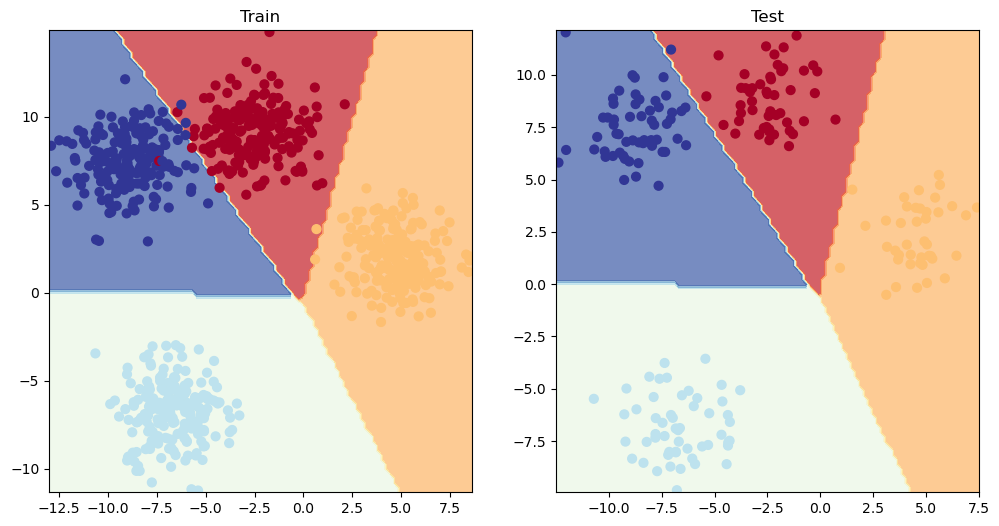

In [79]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)